# To do:


# League of Legends Machine Learning

Load libraries and API key

In [1]:
import requests, json
import numpy as np
from src import API_io
import importlib
import pandas as pd
import pickle
import os
from src import feature_calc
import matplotlib.pyplot as plt
import src.plotting as lol_plt
%matplotlib inline
import pdb

In [2]:
working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\lolML'
os.chdir(working_dir)
with open(working_dir+ '\\api_key.txt', 'r') as api_file:
    api_key =  api_file.read()

In [3]:
working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\lolML\\notebooks'
os.chdir(working_dir)
with open('EUW combined_df.pickle', 'rb') as pickle_file:
    euw_timelines_df = pickle.load(pickle_file)
with open('KR combined_df.pickle', 'rb') as pickle_file:
    kr_timelines_df = pickle.load(pickle_file)
with open('NA combined_df.pickle', 'rb') as pickle_file:
    na_timelines_df = pickle.load(pickle_file)
with open('Low ELO combined_df.pickle', 'rb') as pickle_file:
    low_timelines_df = pickle.load(pickle_file)

In [4]:
# load sklearn package 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [5]:
euw_timelines_df = [feature_calc.calc_secondary_features(x) for x in euw_timelines_df]
na_timelines_df = [feature_calc.calc_secondary_features(x) for x in na_timelines_df]
kr_timelines_df = [feature_calc.calc_secondary_features(x) for x in kr_timelines_df]
low_timelines_df = [feature_calc.calc_secondary_features(x) for x in low_timelines_df]
euw_timelines_df = feature_calc.calc_second_diff(euw_timelines_df)
na_timelines_df = feature_calc.calc_second_diff(na_timelines_df)
kr_timelines_df = feature_calc.calc_second_diff(kr_timelines_df)
low_timelines_df = feature_calc.calc_second_diff(low_timelines_df)

In [15]:
important_col = ['blue_inhibs', 'blue_barons', 'drag_diff', 'first_baron', 'first_inhib',
                 'gold_diff', 'gold_diff_diff', 'kill_diff', 'kill_diff_diff', 'red_barons',
                 'red_inhibs', 'tower_diff']
timeline_end = 55
time_indices = np.arange(5, timeline_end, 5)

In [27]:
import matplotlib as mpl
mpl.rc('font', size=20)
mpl.rc('lines', linewidth=2)

# Get summoner names, and list of matches

Load featured games, and get a list of summoner_names

In [ ]:
featured_json = API_io.load_featured_games(api_key) # load json of featured games
featured_game_ids = [x['gameId'] for x in featured_json ] #  use list comprehension to get featured games; don't use this

Make a list of summoner names and summoner IDs from the featured JSON

In [ ]:
summoner_names, summoner_IDs = API_io.get_summoners_IDs_from_featured_games(featured_json, api_key)
summoner_names[:5]

Make a list of summoner ID urls to query RITO with, and then query them (this is rate limited to one query / 1.2 seconds to avoid overloading API).

In [ ]:
summoner_urls = [API_io.make_matchlist_url_summoner_ID(x, True, True, api_key) for x in summoner_IDs]
summoner_urls[:2]
match_histories = [API_io.get_limited_request(x) for x in summoner_urls ]

Extract the match ID from the match history JSON

In [ ]:
match_IDs = np.empty(0, dtype=int)
for cur_matches in match_histories:
    match_IDs = np.append( match_IDs, [x['matchId'] for x in cur_matches['matches']] )
pd.Series(match_IDs).to_csv('Match IDs.csv')
match_IDs.shape

### Load a csv of match info to skip above steps

In [66]:
match_df = pd.read_csv('Match IDs.csv', header =None)
match_IDs = match_df[1]
match_IDs = match_IDs.unique()
match_IDs.shape

(27928,)

## Query Riot's API for individual game info

Make a list of match urls, and then juse requests to query them; again this is rate limited.

In [67]:
# make urls for loading
match_urls = [API_io.make_match_info_url(x, True, api_key) for x in match_IDs] # True flag means we get the timeline
match_urls[:2]

['https://na.api.pvp.net/api/lol/na/v2.2/match/1955239698?includeTimeline=true&api_key=0da3703d-7bf5-4e72-96cd-5062b28720d7',
 'https://na.api.pvp.net/api/lol/na/v2.2/match/1954974642?includeTimeline=true&api_key=0da3703d-7bf5-4e72-96cd-5062b28720d7']

In [ ]:
import time
import sys
match_range = np.arange(2000,2010)
# this for loop is ugly; used list comprehension previously, but rate limit was fluky
full_match_info = np.empty(0)
for cur_match in match_range:
    time.sleep(1.2) # RIOT API is throttled to ~0.83 requests / second
    try:
        full_match_info = np.append(full_match_info, requests.get(match_urls[cur_match]).json() )
    except requests.exceptions.HTTPError as e:
        print('Error: ' + e + ' in game ' + str(match_IDs[cur_match]))
    except:
        err = sys.exc_info()[0]
        print('Error: ' + str(err) + ' in game ' + str(match_IDs[cur_match]))

Save to a JSON or .pickle so we don't have to query again.

In [ ]:
with open('full matchinfo.csv', 'w') as out_file:
    json.dump(full_match_info.tolist(), out_file)

In [7]:
# saving as a pickle file saves ~%40 of the space
pickle_name = 'full match info.pickle'
if not os.path.isfile(pickle_name):
    with open(pickle_name, 'wb') as pickle_file:
        pickle.dump(full_match_info, pickle_file)

NameError: name 'full_match_info' is not defined

## Load information from local JSON or pickle

In [6]:
# load from JSON
with open('games 6000-8000.json') as json_file:
    scraped_matches= json.load(json_file)
scraped_matches = np.array(full_match_info)

In [5]:
# loading the pickle in
with open('full match info.pickle', 'rb') as pickle_file:
    full_match_info = pickle.load(pickle_file)

# Analyze game data

## Explore and clean data

Plot the length of games

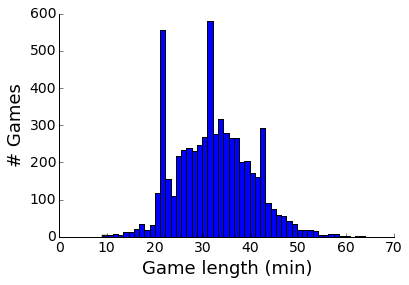

In [15]:
game_lengths = np.array([np.size(x['timeline']['frames']) for x in full_match_info] )
plt.hist(game_lengths, bins = 50);
plt.xlabel('Game length (min)', fontsize = 18)
plt.ylabel('# Games', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

Some games don't even last twenty minutes! There is also a large spike of games ending around 20 minutes due to surrenders. When we create features, the feature calculator will have to consider game length.

## Create features

Create features for the classifier; now just starting with simple stuff like first blood, first tower, and first dragon.

In [22]:
importlib.reload(feature_calc)
games_df = feature_calc.calc_features_all_matches(full_match_info[:100], 20)
games_df.head(3)

,first_dragon,blue_dragons,red_dragons,drag_diff,first_baron,blue_barons,red_barons,first_tower,blue_towers,red_towers,...,blue_3,blue_4,red_0,red_1,red_2,red_3,red_4,surrender,game_length,winner
matchId,,,,,,,,,,,,,,,,,,,,,
1955239698,1,1,1,0,-1,0,0,1,3,2,...,59,429,82,1,2,86,201,1,37,1
1954974642,0,0,2,-2,-1,0,0,0,1,3,...,20,22,56,432,67,101,39,1,32,0
1950969271,0,0,1,-1,-1,0,0,0,2,2,...,60,267,201,238,223,119,150,0,44,0


In [23]:
games_df.dtypes

first_dragon    category
blue_dragons     float64
red_dragons      float64
drag_diff        float64
first_baron     category
blue_barons      float64
red_barons       float64
first_tower     category
blue_towers      float64
red_towers       float64
tower_diff       float64
first_inhib     category
blue_inhibs      float64
red_inhibs       float64
first_blood     category
gold_diff        float64
blue_kills       float64
red_kills        float64
blue_share       float64
red_share        float64
kills_diff       float64
blue_0           float64
blue_1           float64
blue_2           float64
blue_3           float64
blue_4           float64
red_0            float64
red_1            float64
red_2            float64
red_3            float64
red_4            float64
surrender       category
game_length      float64
winner          category
dtype: object

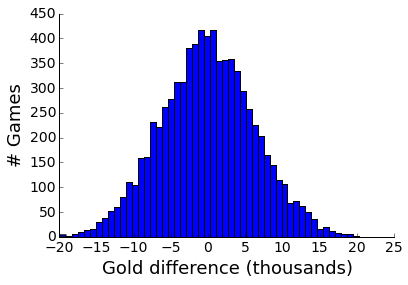

In [23]:
count, bins, _ = plt.hist(games_df['gold_diff'] / 1000, bins = 50)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference (thousands)', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

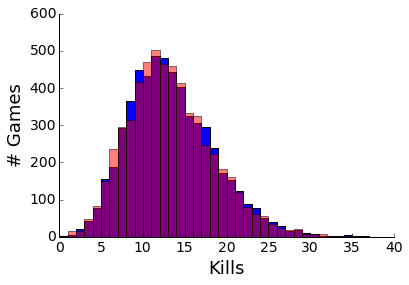

In [41]:
bins = np.arange(40)
kills_fig = plt.figure()
plt.hist(games_df['blue_kills'] , bins = bins, color = 'blue')
plt.hist(games_df['red_kills'] , bins = bins, color = 'red', alpha = 0.5)
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Kills', fontsize = 18)
lol_plt.prettify_axes(plt.gca())
#plt.gca().set_xticklabels(bins / 1000, rotation = 90)

# Run machine learning algorithms: 
## Load libraries, and initialize feature info

In [31]:
# load sklearn package 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [43]:
# variables for classifiers
#col_names = feature_calc.col_names
col_names = na_timelines_df[0].columns
train_col = np.array([x for x in col_names if x not in
             ['winner', 'game_length', 'blue_0', 'blue_1', 'blue_2', 'blue_3', 'blue_4',
              'red_0', 'red_1', 'red_2', 'red_3', 'red_4', 'matchId', 'utctimestamp'] ])
num_features = np.size(train_col)
print(train_col, )

['first_dragon' 'drag_diff' 'total_drag' 'first_baron' 'blue_barons'
 'red_barons' 'first_tower' 'tower_diff' 'total_tower' 'first_inhib'
 'blue_inhibs' 'red_inhibs' 'first_blood' 'gold_diff' 'kill_diff'
 'total_kill' 'blue_share' 'red_share' 'surrender' 'square_gold_diff'
 'gold_diff_diff' 'tower_diff_diff' 'kill_diff_diff' 'drag_diff_diff']


## Naive Bayes:

First let's see how good prediction is with each feature individually

In [ ]:
gnb = GaussianNB()
def quick_score(games_df, col_index):
    gnb.fit(games_df[[col_index]], games_df['winner'])
    return gnb.score(games_df[[col_index]], games_df['winner'])

[quick_score(games_df, x) for x in np.arange(num_features-1)]

First dragon and first tower are both pretty meaningful, but first blood isn't. The most important thing, though, is gold.

Now let's use machine learning to look at everything together. Let's do a 10-fold cross-validation on the data, and see what the average score is.

In [ ]:
scores = cross_validation.cross_val_score(gnb, games_df[train_col], games_df['winner'], cv=10)
print(np.mean(scores))

The full predictor is not that much more informative than the individual parameters! What if we try a:

## SVC Feature importance

Some sample code using built in recursive feature elimination and cross-validation. I never waited long enough for this to finish!

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=3,
              scoring='accuracy')

In [ ]:
# this takes a long time to run
rfecv.fit(timelines_df[-1][train_col], timelines_df[-1]['winner'])

## Random Forest Feature Importance

Start with a large random forest to get a sense of which features are important at different timepoints. First, let's get a dataframe for each timepoint

In [ ]:
timeline_end = 55
time_indices = np.arange(5, timeline_end, 5)
timelines_df = [feature_calc.calc_features_all_matches(full_match_info, x) for x in time_indices]
print([x.shape[0] for x in timelines_df])

In [34]:
big_forest = RandomForestClassifier(n_jobs = 3, n_estimators = 50, max_features = 'sqrt', min_samples_split=15, min_samples_leaf=5)

In [44]:
timelines_df = na_timelines_df
importances = np.zeros([len(timelines_df), np.size(train_col)])
std = np.zeros([len(timelines_df), np.size(train_col)])
for i, cur_df in enumerate(timelines_df):
    big_forest.fit(cur_df[train_col], cur_df['winner'])
    importances[i] = big_forest.feature_importances_
    std[i] = np.std([tree.feature_importances_ for tree in big_forest.estimators_],
                 axis=0)
indices_at_20 = np.argsort(importances[3])[::-1]
indices_at_35 = np.argsort(importances[6])[::-1]
#for f in range(10):
#    print("%d. feature %s (%f)" % (f + 1, str(train_col[indices[f]]), importances[indices[f]]))

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


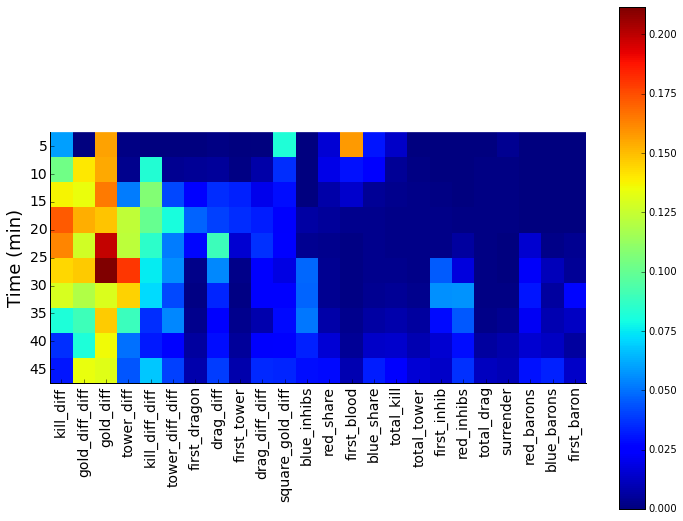

In [45]:
feature_fig = plt.figure(figsize = [12,9])
plt.imshow(importances[:,indices_at_20], interpolation = 'none', extent = [0, num_features*4, 47.5, 2.5])
plt.ylabel('Time (min)', fontsize = 18)
plt.xticks(np.arange(0, num_features*4, 4)+2, indices_at_20)
x_tick_labels = [str(x) for x in train_col[indices_at_20]]
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
lol_plt.prettify_axes(plt.gca())
plt.gca().yaxis.set_ticks(time_indices);
plt.colorbar();

Gold differential is the most important feature at all timepoints, followed by kill differential, and tower differential. Dragon differential comes in late, behind the total number of towers, at #6. Barons and inhibitors are not particularly informative at later timepoints, probably because they are a reflection of gold and kill differentials.

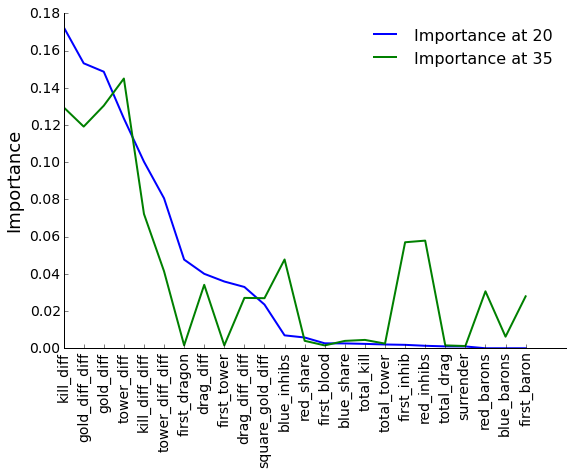

In [46]:
plt.figure(figsize = [9, 6])
plt.plot(importances[3,indices_at_20], label = 'Importance at 20', linewidth = 2)
plt.plot(importances[6,indices_at_20], label = 'Importance at 35', linewidth = 2)
plt.ylabel('Importance', fontsize = 18)
plt.xticks(np.arange(num_features))
x_tick_labels = [str(x) for x in train_col[indices_at_20]]
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
plt.legend(frameon = False, fontsize = 16)
lol_plt.prettify_axes(plt.gca())

Let's extract the important columns for future analyses

In [53]:
import_at_20 = train_col[indices_at_20[:8]]
import_at_35 = train_col[indices_at_35[:12]]
np.unique(np.append(import_at_20, import_at_35))

array(['blue_inhibs', 'drag_diff', 'drag_diff_diff', 'first_baron',
       'first_dragon', 'first_inhib', 'first_tower', 'gold_diff',
       'gold_diff_diff', 'kill_diff', 'kill_diff_diff', 'red_barons',
       'red_inhibs', 'tower_diff', 'tower_diff_diff'], 
      dtype='<U16')

## An aside on carry share

In a previous version of this analysis, I found that the carry share was predictive. It does not really fall out from the new analysis, though. While investigating this metric, though, I found something interesting, which I have kept here. First, let's plot the distribution of carry share.

Median blue carry share: 0.40
Std blue carry share: 0.18


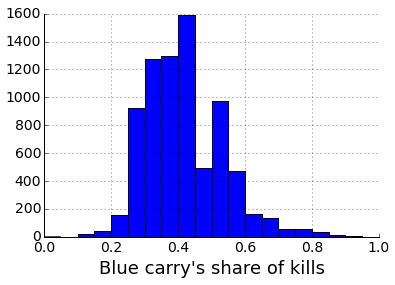

In [160]:
games_df['blue_share'].hist(bins = np.arange(0, 1, 0.05))
lol_plt.prettify_axes(plt.gca())
plt.xlabel('Blue carry\'s share of kills', fontsize = 18)
print('Median blue carry share: {:.2f}\nStd blue carry share: {:.2f}'.format(games_df['blue_share'].median(), games_df['blue_share'].std()))

The median carry ratio is 0.4, with a standard deviation of ~0.2. Now let's plot the win percentage against the carry share.

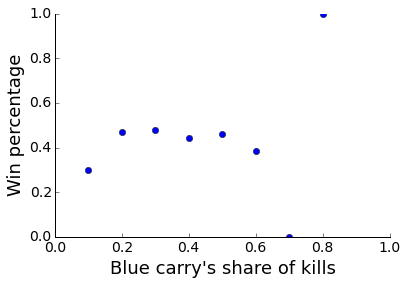

In [91]:
games_df = timelines_df[6]
share_indices = np.arange(0, 1.0+0.1, 0.1)
win_percent_by_share = games_df['winner'].astype(int).groupby(pd.cut(games_df["blue_share"], share_indices)).mean()
plt.plot(share_indices[:-1], win_percent_by_share, 'o')
plt.xlim([0, 1])
plt.xlabel('Blue carry\'s share of kills', fontsize = 18)
plt.ylabel('Win percentage', fontsize = 18)
lol_plt.prettify_axes(plt.gca())

The win percentage goes down as the carry share increases. This means that teams which have all the kills weighted onto one team are less likely to win. If you get far ahead in your lane, it's less important for you to keep your lane opponent down than it is to get the rest of your team fed.

## Does game get more predictable over time?

Now that we have features that are important, we can answer other questions.

In [55]:
rfc = RandomForestClassifier(n_jobs = 2, n_estimators = 25, max_features = 'sqrt', min_samples_leaf= 5, min_samples_split=15)
def cross_validate_df(cur_df):
    return cross_validation.cross_val_score(rfc, cur_df[important_col], cur_df['winner'], cv=3, n_jobs = 2)

scores_list = [cross_validate_df(x) for x in timelines_df]

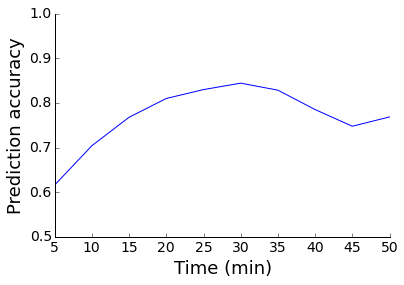

In [62]:
plt.plot(time_indices, np.mean(scores_list, 1))
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)', fontsize = 18)
plt.ylabel('Prediction accuracy', fontsize = 18)
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())

The game does get more easily predicted with time, as more information is gathered by the model. However, once you reach 30 minutes, the model loses accuracy. This is probably because as the game enters the late phase, gold matters less, and objectives more, and a single decisive teamfight can decide the game either way.

## Are surrendered games winnable?

First, separate games into surrendered early, and those that were semi-close.

In [99]:
surrender_at_20_df = timelines_df[3].query('(surrender == 1) & (game_length <=25)')
good_games_df = timelines_df[3].query('(surrender == 0) | (game_length >25)')
surrender_at_20_df[['surrender', 'game_length']].head(2)

,surrender,game_length
matchId,,
1947508622,1,22
1947379227,1,25


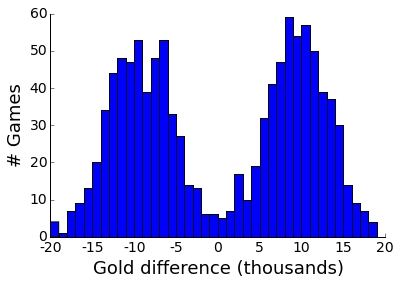

In [133]:
gold_bins = np.arange(-20000, 20000, 1000)
plt.hist(np.array(surrender_at_20_df['gold_diff']), bins=gold_bins)
plt.xlabel('Gold difference (thousands)', fontsize = 18)
plt.ylabel('# Games', fontsize = 18)
plt.gca().set_xticklabels(np.arange(-20, 21, 5))
lol_plt.prettify_axes(plt.gca())

Since these are stomps, the gold difference is bimodal towards large leads. However, there are a few games with small gold leads. First, let's see how accurate the random forest is for these stomps. (It should be high!)

In [101]:
surrender_forest = RandomForestClassifier(n_jobs = 2, n_estimators = 10, max_features = 'sqrt')
surrender_scores = cross_validation.cross_val_score(surrender_forest, surrender_at_20_df[important_col], surrender_at_20_df['winner'], cv=10)
print('Forest mean accuracy for surrendered games: {:.2f}'.format(np.mean(surrender_scores)))

Forest mean accuracy for surrendered games: 0.99


Pretty damn good! Ok, what happens if we train the model on the "close" games, and use it to predict the probability of winning surrendered ones?

In [102]:
close_forest = RandomForestClassifier(n_jobs = 3, n_estimators = 20, max_features = 'sqrt')
close_forest.fit(good_games_df[important_col], good_games_df['winner'])
cross_score = np.mean(np.max(close_forest.predict_proba(surrender_at_20_df[important_col]), axis = 1))
print('A forest trained on non-surrender games predicts the team that won would do so with {:.2f} probability'.format(cross_score))

A forest trained on non-surrender games predicts the team that won would do so with 0.93 probability


The random forest trained on close games actually gives games surrendered at 20 a 7% chance of winning!

# Exploring hyper-parameters
## Model accuracy dependancy on samples

How many samples do we have for each point?

In [8]:
[x.shape[0] for x in euw_timelines_df]

[25157, 25133, 24887, 24169, 20032, 15125, 8802, 3940, 1322, 330]

Make functions to run cross-validated models at each time point, then run THAT function using different sample size

In [33]:
rfc = RandomForestClassifier(n_jobs = 4, n_estimators = 20, max_features = 'sqrt')
def cross_validate_df(cur_df):
    return cross_validation.cross_val_score(rfc, cur_df[important_col], cur_df['winner'], cv=5, n_jobs = 4)

def calc_score_per_samples(timelines_df, n_samples):
    timelines_scores = [cross_validate_df(x.sample(min(x.shape[0], n_samples)) ) for x in timelines_df]
    return np.mean(timelines_scores, 1)
sample_range = np.arange(1000, 18000, 2000)
scores_per_samples = [ calc_score_per_samples(euw_timelines_df, x) for x in sample_range]

Now plot the model accuracy for different sample numbers.

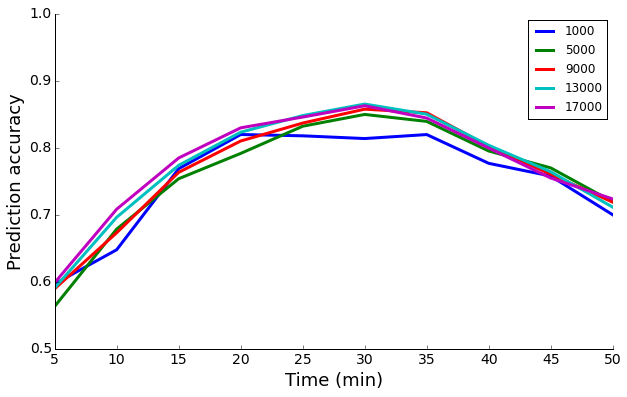

In [53]:
plt.figure(figsize = [10, 6])
[plt.plot(time_indices, x, linewidth = 3, label = sample_range[2 * i]) for i, x in enumerate(scores_per_samples[::2])]
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)', fontsize = 18)
plt.ylabel('Prediction accuracy', fontsize = 18)
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend();

The model improves from 1000 to 5000 samples, and a little more to 9000 samples, but beyond that it doesn't improve much

## Forest size versus prediction accuracy

How does increasing the forest size impact the accuracy of the model? We'll vary the forest size from 5 to 205

In [15]:
forest_sizes = np.arange(5, 205, 25)
def score_by_size(cur_size):
    size_forest = RandomForestClassifier(n_jobs = 4, n_estimators = cur_size, max_features = 'sqrt')
    return cross_validation.cross_val_score(size_forest, euw_timelines_df[3][important_col],  euw_timelines_df[3]['winner'], cv=5, n_jobs = 4)

size_scores = list(map(score_by_size, forest_sizes))

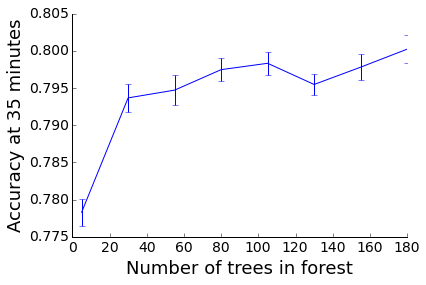

In [17]:
plt.errorbar(forest_sizes, np.mean(size_scores, 1), np.std(size_scores, 1) / np.sqrt(5))
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy at 35 minutes', fontsize = 18)
plt.xlabel('Number of trees in forest', fontsize = 18)
#plt.ylim([0.8, 0.85]);

The accuracy increased noticeably from 5 to 25 forests, but not much from there.

## Grid search

In [71]:
from sklearn.grid_search import GridSearchCV
param_dict = { 'max_depth' : list(range(5, 16, 5)), 'min_samples_leaf': list(range(2,23,10)),
              'min_samples_split': list(range(10, 51, 10))}
grid_tree = GridSearchCV(RandomForestClassifier( n_estimators = 50, max_features = 'sqrt'),
                        param_grid = param_dict, cv = 3, n_jobs = 3)
grid_df = na_timelines_df[0]
grid_tree.fit(grid_df[important_col], grid_df['winner'])

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'min_samples_split': [10, 20, 30, 40, 50], 'max_depth': [5, 10, 15], 'min_samples_leaf': [2, 12, 22]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [74]:
grid_tree.grid_scores_

[mean: 0.63139, std: 0.00255, params: {'min_samples_split': 10, 'max_depth': 5, 'min_samples_leaf': 2},
 mean: 0.63178, std: 0.00279, params: {'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 2},
 mean: 0.63133, std: 0.00248, params: {'min_samples_split': 30, 'max_depth': 5, 'min_samples_leaf': 2},
 mean: 0.63145, std: 0.00328, params: {'max_depth': 5, 'min_samples_split': 40, 'min_samples_leaf': 2},
 mean: 0.63133, std: 0.00367, params: {'min_samples_split': 50, 'max_depth': 5, 'min_samples_leaf': 2},
 mean: 0.63139, std: 0.00362, params: {'min_samples_split': 10, 'max_depth': 5, 'min_samples_leaf': 12},
 mean: 0.63125, std: 0.00334, params: {'min_samples_split': 20, 'max_depth': 5, 'min_samples_leaf': 12},
 mean: 0.63167, std: 0.00437, params: {'min_samples_split': 30, 'max_depth': 5, 'min_samples_leaf': 12},
 mean: 0.63122, std: 0.00336, params: {'min_samples_split': 40, 'max_depth': 5, 'min_samples_leaf': 12},
 mean: 0.63186, std: 0.00314, params: {'min_samples_split': 

## Dependency on depth and min samples split:

In [21]:
def score_by_min_split(cur_min_split, cur_timelines):
    split_forest = RandomForestClassifier(n_jobs = -1, n_estimators = 25, max_features = 'sqrt', min_samples_split = cur_min_split)
    return cross_validation.cross_val_score(split_forest, cur_timelines[2][important_col],  cur_timelines[2]['winner'], cv=10, n_jobs = -1)

min_samples_array = list(range(1, 25, 5))
min_split_scores = list(map(lambda x: score_by_min_split(x, na_timelines_df), min_samples_array))

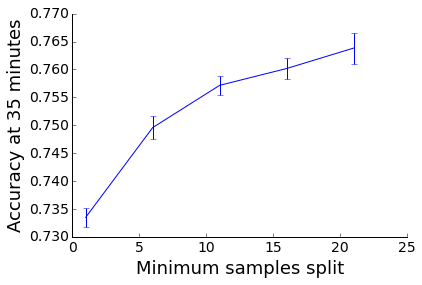

In [22]:
plt.errorbar(min_samples_array, np.mean(min_split_scores, 1), np.std(min_split_scores, 1) / np.sqrt(5))
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy at 35 minutes', fontsize = 18)
plt.xlabel('Minimum samples split', fontsize = 18)
#plt.ylim([0.8, 0.85]);

# League specific questions:
## Are regions similarly predictable?

In [6]:
rfc = RandomForestClassifier(n_jobs = -1, n_estimators = 25, max_features = 'sqrt')
def cross_validate_df(cur_df, n_samples = 10000):
    sample_df = cur_df.sample(min(cur_df.shape[0], n_samples))
    return cross_validation.cross_val_score(rfc, sample_df[important_col], sample_df['winner'], cv=5, n_jobs = -1)

In [55]:
kr_scores = list(map(cross_validate_df, kr_timelines_df))
na_scores = list(map(cross_validate_df, na_timelines_df))
euw_scores = list(map(cross_validate_df, euw_timelines_df))

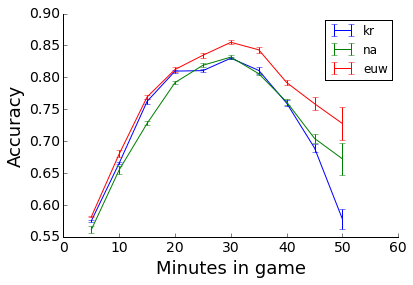

In [57]:
cv = np.shape(euw_scores)[1]
plt.errorbar(time_indices, np.mean(kr_scores, 1), np.std(kr_scores, 1) / np.sqrt(cv), label = 'kr')
plt.errorbar(time_indices, np.mean(na_scores, 1), np.std(na_scores, 1) / np.sqrt(cv), label = 'na')
plt.errorbar(time_indices, np.mean(euw_scores, 1), np.std(euw_scores, 1) / np.sqrt(cv), label = 'euw')
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Minutes in game', fontsize = 18)
plt.xlim([0, 60])
plt.legend();

In [36]:
[x[0]['surrender'].astype(int).mean() for x in [euw_timelines_df, kr_timelines_df, na_timelines_df] ]

[0.8636164884525181, 0.8707361248867997, 0.8670877232205237]

## Do regions do well predicting for each other?

In [41]:
rfc = RandomForestClassifier(n_jobs = -1, n_estimators = 25, max_features = 'sqrt')
def score_cross_region(train_df, test_df, n_samples = 10000):
    # train a random forest classifier on training data from one region, then score it on a different region
    train_sample_df = train_df.sample(min(train_df.shape[0], n_samples))
    rfc.fit(train_sample_df[important_col], train_sample_df['winner'])
    return rfc.score(test_df[important_col], test_df['winner'])

In [58]:
na_eu_cross_scores = [score_cross_region(x, y) for x,y in zip(na_timelines_df, euw_timelines_df)]
eu_na_cross_scores = [score_cross_region(x, y) for x,y in zip(euw_timelines_df, na_timelines_df)]
eu_kr_cross_scores = [score_cross_region(x, y) for x,y in zip(euw_timelines_df, kr_timelines_df)]
na_kr_cross_scores = [score_cross_region(x, y) for x,y in zip(na_timelines_df, kr_timelines_df)]

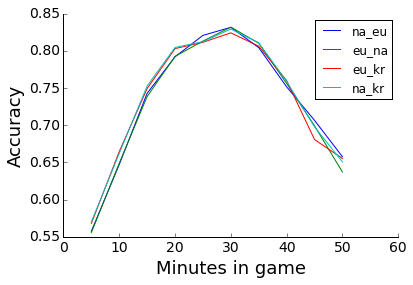

In [60]:
plt.plot(time_indices, na_eu_cross_scores, label = 'na_eu')
plt.plot(time_indices, eu_na_cross_scores, label = 'eu_na')
plt.plot(time_indices, eu_kr_cross_scores, label = 'eu_kr')
plt.plot(time_indices, na_kr_cross_scores, label = 'na_kr')
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Minutes in game', fontsize = 18)
plt.xlim([0, 60])
plt.legend();

## How does skill level impact predictability?

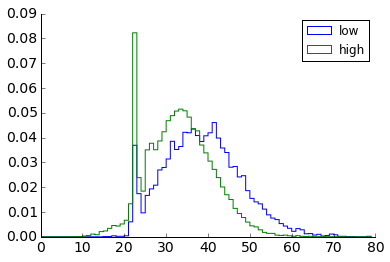

In [45]:
low_lengths =np.array( low_timelines_df[0]['game_length'])
high_lengths = np.array( na_timelines_df[0]['game_length'])
plt.hist(low_lengths, bins = range(0, 80), histtype='step', normed=True, label = 'low')
plt.hist(high_lengths, bins = range(0, 80), histtype='step', normed=True,label = 'high')
lol_plt.prettify_axes(plt.gca())
plt.xlabel('Game Length')
plt.legend(frameon=False);

In [14]:
rfc = RandomForestClassifier(n_jobs = -1, n_estimators = 25, max_features = 'sqrt', min_samples_split=10)
def cross_validate_df(cur_df, n_samples = 10000):
    sample_df = cur_df.sample(min(cur_df.shape[0], n_samples))
    return cross_validation.cross_val_score(rfc, sample_df[important_col], sample_df['winner'], cv=10, n_jobs = -1)

In [15]:
low_scores = [cross_validate_df(x) for x in low_timelines_df]
high_scores = [cross_validate_df(x) for x in na_timelines_df]

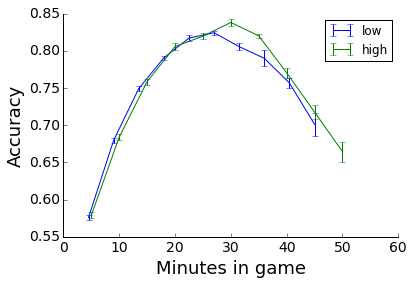

In [47]:
plt.errorbar(time_indices *0.9, np.mean(low_scores, 1), np.std(low_scores, 1) / np.sqrt(10), label = 'low')
plt.errorbar(time_indices, np.mean(high_scores, 1), np.std(high_scores, 1) / np.sqrt(10), label = 'high')
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Minutes in game', fontsize = 18)
plt.xlim([0, 60])
plt.legend();

## Preseason 2016

In [11]:
with open('Preseason2016 combined_df.pickle', 'rb') as pickle_file:
    pre2016_timelines_df = pickle.load(pickle_file)
pre2016_timelines_df = [feature_calc.calc_secondary_features(x) for x in pre2016_timelines_df]
pre2016_timelines_df = feature_calc.calc_second_diff(pre2016_timelines_df)

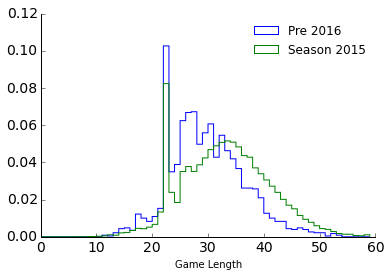

In [21]:
pre_2016_lengths =np.array( pre2016_timelines_df[0]['game_length'])
season_2015_lengths = np.array( na_timelines_df[0]['game_length'])
plt.hist(pre_2016_lengths, bins = range(0, 60), histtype='step', normed=True, label = 'Pre 2016')
plt.hist(season_2015_lengths, bins = range(0, 60), histtype='step', normed=True,label = 'Season 2015')
lol_plt.prettify_axes(plt.gca())
plt.xlabel('Game Length')
plt.legend(frameon=False);

In [18]:
rfc = RandomForestClassifier(n_jobs = -1, n_estimators = 30, max_features = 'sqrt',
                             min_samples_leaf=10, min_samples_split=25, max_depth=10)
def cross_validate_df(cur_df, n_samples = 2200):
    sample_df = cur_df.sample(min(cur_df.shape[0], n_samples))
    return cross_validation.cross_val_score(rfc, sample_df[important_col], sample_df['winner'], cv=4, n_jobs = -1)
pre_2016_scores = [cross_validate_df(x) for x in pre2016_timelines_df]
season_2015_scores = [cross_validate_df(x) for x in na_timelines_df]

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=4.
  % (min_labels, self.n_folds)), Warning)


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


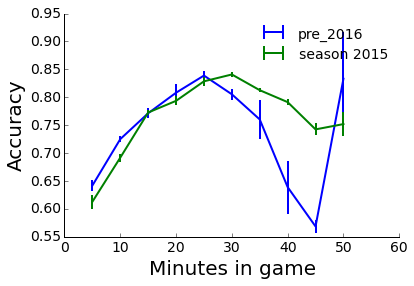

In [28]:
plt.errorbar(time_indices, np.mean(pre_2016_scores, 1), np.std(pre_2016_scores, 1) / np.sqrt(4), label = 'pre_2016', capsize=0)
plt.errorbar(time_indices, np.mean(season_2015_scores, 1), np.std(season_2015_scores, 1) / np.sqrt(4), label = 'season 2015', capsize=0)
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy')
plt.xlabel('Minutes in game')
plt.xlim([0, 60])
plt.legend(fontsize = 14,frameon=False);